In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
def cargar_depurar_datos(archivo):
    """
    Carga y depura un archivo CSV de precios de Bitcoin mensual,
    devolviendo tanto el DataFrame limpio como una estructura
    tipo lista de diccionarios de diccionarios.
    """
    
    df = pd.read_csv(archivo, skiprows=2)

    
    df = df.rename(columns={
        "Date": "Date",
        "Unnamed: 1": "Close",
        "Unnamed: 2": "High",
        "Unnamed: 3": "Low",
        "Unnamed: 4": "Open",
        "Unnamed: 5": "Volume"
    })

    
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

   
    df.dropna(inplace=True)

   
    df.set_index("Date", inplace=True)

    return df
archivo = "C:/Users/jeron/OneDrive/Escritorio/CoinPredictor/Datos/bitcoin_diario.csv"
df = cargar_depurar_datos(archivo)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4029 entries, 2014-09-17 to 2025-09-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4029 non-null   float64
 1   High    4029 non-null   float64
 2   Low     4029 non-null   float64
 3   Open    4029 non-null   float64
 4   Volume  4029 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 188.9 KB
None


In [3]:
set_entrenamiento = df.loc[:"2023-12-31"].iloc[:,1:2]
set_validacion = df.loc["2024-01-01":].iloc[:,1:2]

set_entrenamiento.info()
set_validacion.info()

set_entrenamiento.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3393 entries, 2014-09-17 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    3393 non-null   float64
dtypes: float64(1)
memory usage: 53.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 636 entries, 2024-01-01 to 2025-09-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    636 non-null    float64
dtypes: float64(1)
memory usage: 9.9 KB


,High
Date,
2023-12-27,43683.160156
2023-12-28,43804.781250
2023-12-29,43124.324219
2023-12-30,42584.125000
2023-12-31,42860.937500


In [9]:

scaler = MinMaxScaler((0, 1))
train_scaled = scaler.fit_transform(set_entrenamiento.values)
val_scaled = scaler.transform(set_validacion.values)

print(train_scaled[:-10])
print(val_scaled[:-10])

[[0.00373944]
 [0.00357446]
 [0.00315122]
 ...
 [0.6291031 ]
 [0.6425373 ]
 [0.64202813]]
[[0.64107694]
 [0.66622017]
 [0.66043893]
 [0.64974717]
 [0.64367031]
 [0.64183805]
 [0.6457451 ]
 [0.68544346]
 [0.69529648]
 [0.69170237]
 [0.71098188]
 [0.67494644]
 [0.62735856]
 [0.6248933 ]
 [0.62859894]
 [0.63219414]
 [0.62670574]
 [0.62213367]
 [0.61131112]
 [0.60757426]
 [0.60724577]
 [0.60426872]
 [0.58204792]
 [0.58724542]
 [0.58390171]
 [0.61240807]
 [0.61220751]
 [0.62097919]
 [0.6283969 ]
 [0.63617023]
 [0.63439795]
 [0.62748263]
 [0.63009747]
 [0.62918541]
 [0.62536061]
 [0.63114389]
 [0.62895512]
 [0.64350501]
 [0.66149755]
 [0.69907024]
 [0.69897802]
 [0.70466157]
 [0.73010037]
 [0.73123651]
 [0.75548602]
 [0.76713256]
 [0.76301902]
 [0.75797287]
 [0.76037963]
 [0.7622222 ]
 [0.76895508]
 [0.76055245]
 [0.75531457]
 [0.74785327]
 [0.75056934]
 [0.75444569]
 [0.79801874]
 [0.83592694]
 [0.92889119]
 [0.92411577]
 [0.91783761]
 [0.9076827 ]
 [0.91893286]
 [0.99631669]
 [1.00555573]


In [ ]:
time_step = 60
X_train = []
Y_train = []
m = len(train_scaled)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(train_scaled[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(train_scaled[i,0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Convertir a tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)

print(X_train_t.shape, Y_train_t.shape)

torch.Size([3333, 60, 1]) torch.Size([3333, 1])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


neuronas = 100         
dim_salida = 1
batch_size = 32
epochs = 50
lr = 1e-3              

# Dataset
train_ds = TensorDataset(X_train_t, Y_train_t)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Modelo
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=100):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=1,batch_first=True)      
        self.fc = nn.Linear(hidden_size, dim_salida)

    def forward(self, x):
       
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = out[:, -1, :]            
        y = self.fc(last_hidden)               
        return y

model = LSTMRegressor(input_size=1, hidden_size=neuronas).to(device)
print(model)


criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

# ====== Entrenamiento ======
print("Comenzando el entrenamiento...")
model.train()
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Época {epoch:03d} | MSE: {epoch_loss:.6f}")

print("Entrenamiento completado exitosamente")


Device: cpu
LSTMRegressor(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Comenzando el entrenamiento...
Época 001 | MSE: 0.080985
Época 005 | MSE: 0.000426
Época 010 | MSE: 0.000354
Época 015 | MSE: 0.000339
Época 020 | MSE: 0.000228
Época 025 | MSE: 0.000214
Época 030 | MSE: 0.000206
Época 035 | MSE: 0.000155
Época 040 | MSE: 0.000169
Época 045 | MSE: 0.000144
Época 050 | MSE: 0.000155
Entrenamiento completado exitosamente


In [14]:
model.eval()
x_test = set_validacion.values
x_test_scaled = scaler.transform(x_test)

X_test = []
for i in range(time_step, len(x_test_scaled)):
    X_test.append(x_test_scaled[i - time_step:i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    pred_scaled = model(X_test_t).cpu().numpy()

prediccion = scaler.inverse_transform(pred_scaled)
print(prediccion)

[[ 66735.35 ]
 [ 66276.53 ]
 [ 65568.15 ]
 [ 66394.05 ]
 [ 72460.96 ]
 [ 72332.28 ]
 [ 70446.125]
 [ 71258.336]
 [ 73520.16 ]
 [ 71427.875]
 [ 73240.1  ]
 [ 76427.766]
 [ 75838.49 ]
 [ 76841.74 ]
 [ 76875.94 ]
 [ 75138.04 ]
 [ 72640.03 ]
 [ 71579.61 ]
 [ 71795.9  ]
 [ 70840.44 ]
 [ 71012.234]
 [ 71170.2  ]
 [ 69307.2  ]
 [ 68815.7  ]
 [ 70873.516]
 [ 74763.57 ]
 [ 74635.29 ]
 [ 74859.984]
 [ 74661.76 ]
 [ 73861.88 ]
 [ 73266.71 ]
 [ 74537.88 ]
 [ 74309.44 ]
 [ 72389.74 ]
 [ 69407.99 ]
 [ 72634.65 ]
 [ 71567.125]
 [ 72690.625]
 [ 73446.34 ]
 [ 76174.54 ]
 [ 74637.27 ]
 [ 74028.34 ]
 [ 74355.7  ]
 [ 74206.375]
 [ 70317.86 ]
 [ 68375.25 ]
 [ 69952.83 ]
 [ 66770.016]
 [ 67324.7  ]
 [ 66996.164]
 [ 68603.43 ]
 [ 68413.87 ]
 [ 68763.69 ]
 [ 70543.2  ]
 [ 70240.164]
 [ 70088.77 ]
 [ 68009.7  ]
 [ 67672.01 ]
 [ 66685.09 ]
 [ 67275.64 ]
 [ 67071.12 ]
 [ 67724.32 ]
 [ 63080.555]
 [ 62258.773]
 [ 66829.34 ]
 [ 67584.25 ]
 [ 67587.305]
 [ 68753.086]
 [ 67286.625]
 [ 65749.08 ]
 [ 66445.56 ]
 [ 663

In [15]:
p = np.mean(prediccion)
t = np.mean(x_test)
ac = 0
if p > t:
    ac = round((t / p) * 100, 2)
else:
    ac = round((p / t) * 100, 2)
print(str(ac) + '%')

93.23%


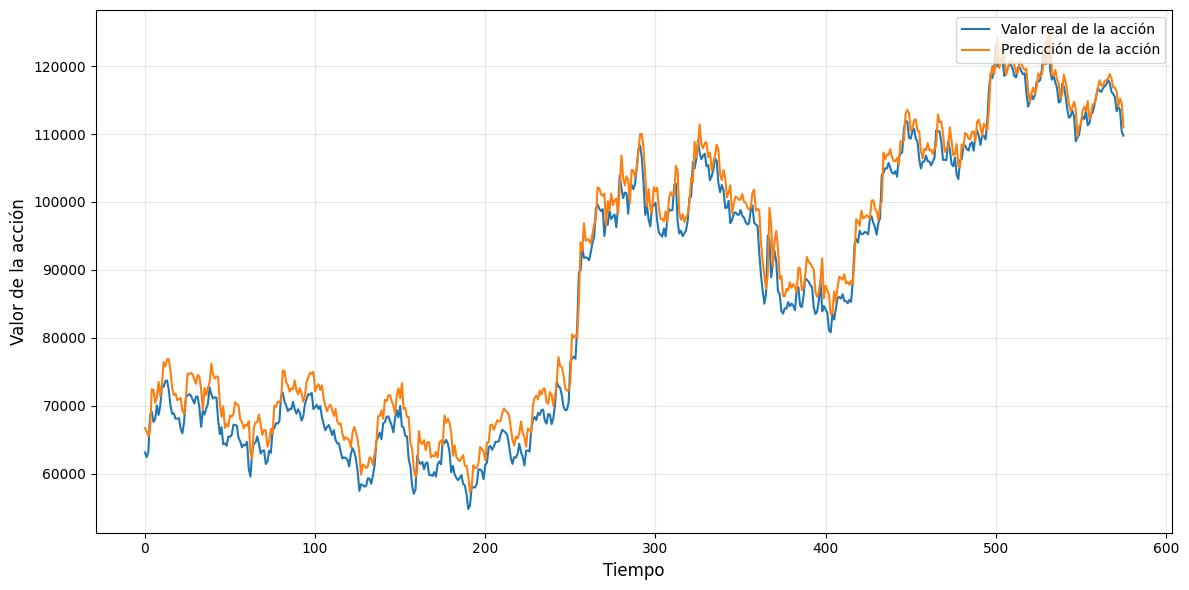

In [16]:
fechas_validacion = set_validacion.index[time_step:]
valores_reales = set_validacion.iloc[time_step:, 0].values

plt.figure(figsize=(12, 6))
plt.plot(valores_reales, label='Valor real de la acción', linewidth=1.5)
plt.plot(prediccion.reshape(-1), label='Predicción de la acción', linewidth=1.5)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Valor de la acción', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
rentability = 1
pred_vec = prediccion.reshape(-1)
for i in range(1, len(valores_reales)):
    if pred_vec[i] > valores_reales[i - 1]:
        rentability *= valores_reales[i] / valores_reales[i - 1]
print((rentability - 1) * 100, "%")

75.56655677594041 %
